In [2]:
import pandas as pd
import msgpack

In [3]:
def _to_str_keys(d):
    if isinstance(d, list):
        return [_to_str_keys(di) for di in d]
    if isinstance(d, dict):
        out = {}
        for k, v in d.items():
            out[_to_str_keys(k)] = _to_str_keys(v)
        return out
    if isinstance(d, bytes):
        return d.decode()
    return d
    


In [4]:
from sklearn.utils import check_random_state
def shape_history(history, **kwargs):
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    hist_df = pd.DataFrame(history)
    for _, row in hist_df.iterrows():
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 **row,
                 **kwargs}]
    return out

In [5]:
def get_final_scores(hist):
    df = pd.DataFrame(hist)

    show = df.pivot_table(
        index="model_id",
        values="cumulative_partial_fit_calls",
        aggfunc="idxmax",
    )
    final_calls = show.values.flatten()

    s = df.loc[final_calls]

    final_scores = s.pivot_table(
        index="bracket",
        values="score",
        aggfunc="max",
    )
    return final_scores

In [6]:
today = "2019-07-08"
with open(f"out/{today}-histories-2.msgpack", "rb") as f:
    histories = msgpack.load(f)

histories = _to_str_keys(histories[b"hyperband"])

In [7]:
shaped_hists = [shape_history(h) for h in histories]

In [8]:
get_final_scores(shaped_hists[0])

,score
bracket,
0,0.315859
1,0.906190
2,0.842970
3,0.897193
4,0.901272


In [9]:
final_scores = [get_final_scores(h) for h in shaped_hists]

In [10]:
final_scores = pd.concat(final_scores, axis=1).T.reset_index(drop=True)

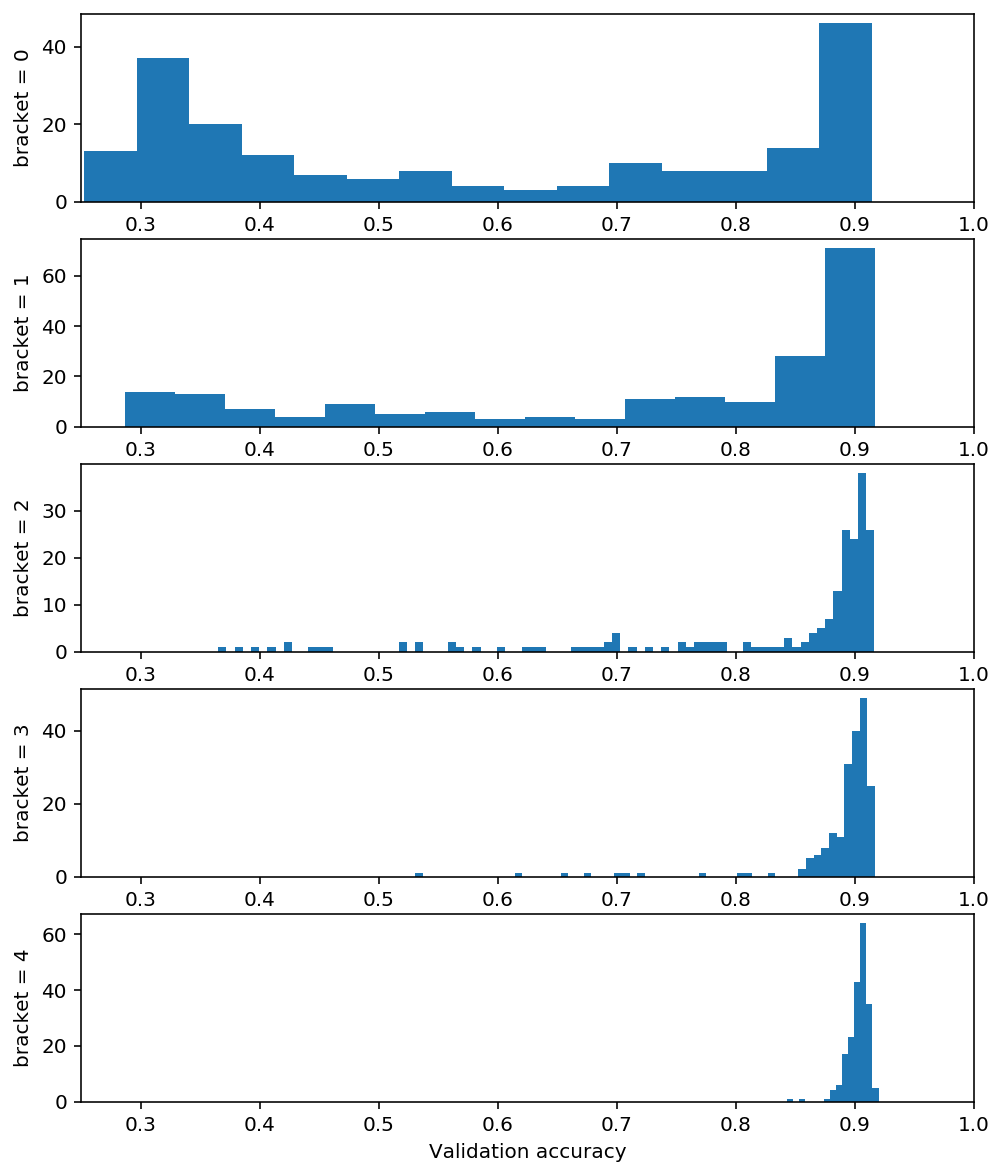

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

w = 2
fig, axs = plt.subplots(nrows=5, figsize=(4 * w, 5 * w))

for i, ax in enumerate(axs):
    bins = 15
    if i == 3:
        bins = 60
    if i == 2:
        bins = 80
    _ = ax.hist(
        final_scores[i],
        bins=bins,
    )
    _ = ax.set_ylabel(f"bracket = {i}")
    _ = ax.set_xlim(0.25, 1)
    if i == 4:
        _ = ax.set_xlabel("Validation accuracy")
plt.savefig("brackets.png", dpi=100, bbox_inches="tight")

In [29]:
best_bracket = final_scores.idxmax(axis="columns")
best_bracket = best_bracket.value_counts()#.reset_index(name="count")
best_bracket.index.name = "bracket"
best = best_bracket.reset_index(name="count")
best

,bracket,count
0,4,84
1,3,53
2,2,36
3,1,20
4,0,7


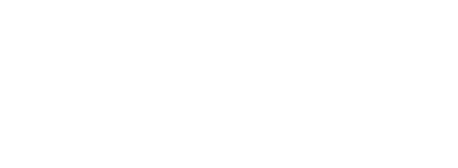

In [30]:
import altair as alt
alt.Chart(best, title="Best performing bracket").mark_bar().encode(
    y="bracket:O",
    x="count",
)

In [58]:
def explore(pdf, runs=1, seed=None):
    rng = check_random_state(seed)
    i = rng.choice(len(pdf), size=runs)
    return pdf[i].max()

pdf = final_scores[4]
pdf2 = [explore(pdf, runs=2, seed=None) for k in range(1000)]
pdf3 = [explore(pdf, runs=3, seed=None) for k in range(1000)]
pdf4 = [explore(pdf, runs=4, seed=None) for k in range(1000)]
pdf5 = [explore(pdf, runs=5, seed=None) for k in range(1000)]


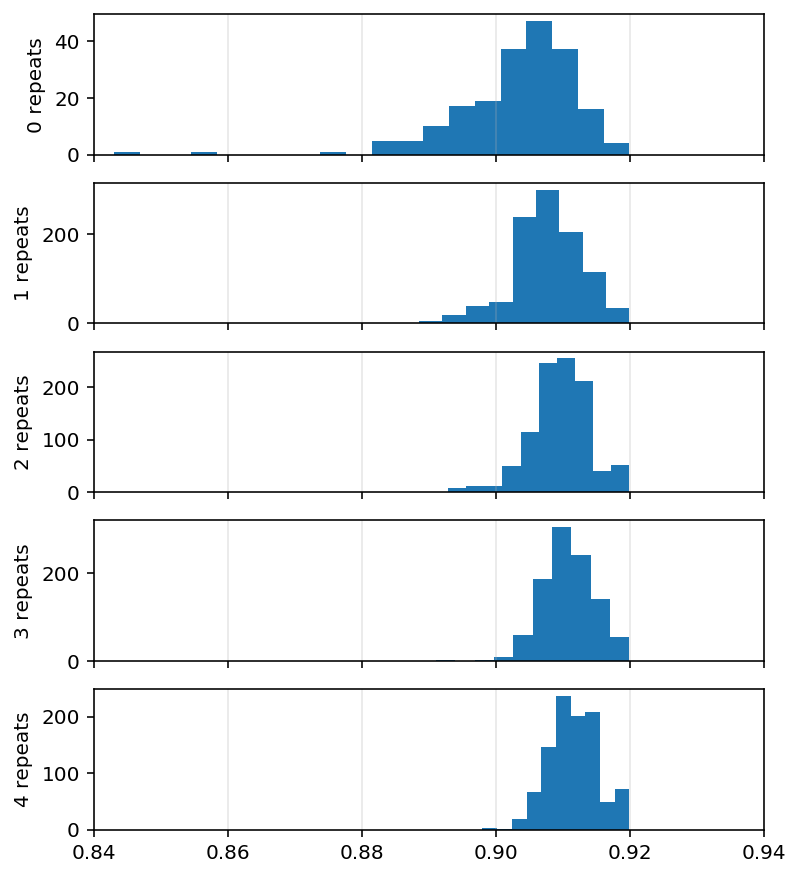

In [74]:
w = 1.5
fig, axs = plt.subplots(nrows=5, figsize=(4 * w, 5 * w))
kwargs = {"alpha": 1.0}
axs[0].hist(pdf, label=1, bins=20, **kwargs)
axs[1].hist(pdf2, label=2, **kwargs)
axs[2].hist(pdf3, label=3, **kwargs)
axs[3].hist(pdf4, label=4, **kwargs)
axs[4].hist(pdf5, label=5, **kwargs)
for k, ax in enumerate(axs):
    _ = ax.set_xlim(0.84, 0.94)
    _ = ax.set_ylabel(f"{k} repeats")
    _ = ax.grid(alpha=0.3, axis="x")
    if k <= 3:
        _ = ax.set_xticklabels([])

In [138]:
h_pdf = final_scores.max(axis="columns")

Text(0.5, 1.0, 'Best scores')

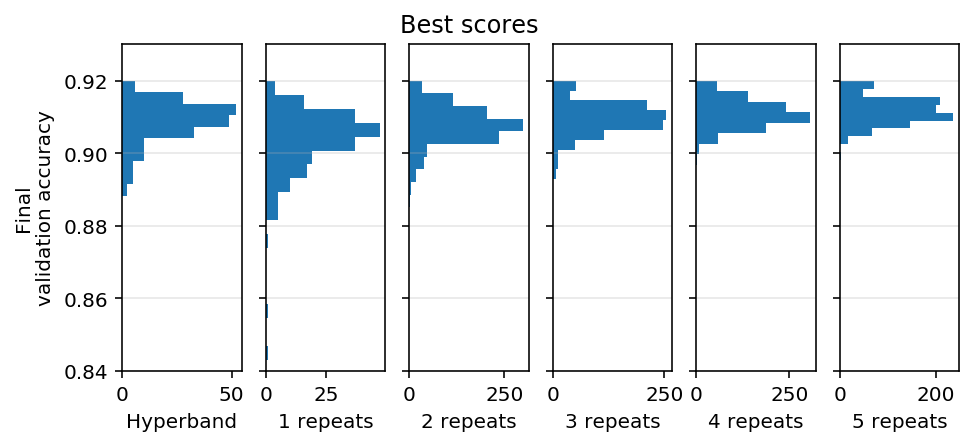

In [150]:
w = 1.5
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(5 * w, 2 * w))
kwargs = {"alpha": 1.0, "orientation": "horizontal"}
axs[0].hist(h_pdf, **kwargs)
axs[1].hist(pdf, label=1, bins=20, **kwargs)
axs[2].hist(pdf2, label=2, **kwargs)
axs[3].hist(pdf3, label=3, **kwargs)
axs[4].hist(pdf4, label=4, **kwargs)
axs[5].hist(pdf5, label=5, **kwargs)

# font = {"weight": "bold"}
font = {}
for k, ax in enumerate(axs):
    _ = ax.set_ylim(0.84, 0.93)
    if k != 0:
        _ = ax.set_xlabel(f"{k} repeats", fontdict=font)
    else:
        _ = ax.set_xlabel("Hyperband", fontdict=font)
    _ = ax.grid(alpha=0.3, axis="y")
    if k != 0:
        _ = ax.set_yticklabels([])
    else:
        _ = ax.set_ylabel("Final\nvalidation accuracy", fontdict=font)
axs[2].set_title("Best scores", fontdict=font)

In [122]:
import numpy as np
data = []
for k, p in enumerate([pdf, pdf2, pdf3, pdf4, pdf5]):
    p = np.asarray(p)
    meta = {"repeats": k + 1}
    stats = {k: getattr(p, k)() for k in ["mean", "min", "max"]}
    percentiles = {f"p{perc}": np.percentile(p, perc) for perc in [10, 5, 95, 20, 25, 75, 30, 40, 50, 60, 70, 80, 90]}
    data.append({**meta, **stats, **percentiles})

In [123]:
df = pd.DataFrame(data)
df.head()

,max,mean,min,p10,p20,p25,p30,p40,p5,p50,p60,p70,p75,p80,p90,p95,repeats
0,0.919986,0.903066,0.842970,0.892370,0.896929,0.898482,0.901080,0.903407,0.888388,0.904870,0.906718,0.908265,0.908889,0.909597,0.912200,0.914227,1
1,0.919986,0.907655,0.885077,0.901871,0.903671,0.904870,0.905350,0.906910,0.898273,0.908229,0.909189,0.909909,0.910749,0.911972,0.914227,0.914827,2
2,0.919986,0.909526,0.892874,0.904511,0.906526,0.907030,0.907750,0.908469,0.902711,0.909429,0.909909,0.911948,0.912188,0.913268,0.914467,0.917946,3
3,0.919986,0.910733,0.891075,0.906070,0.907869,0.908349,0.908709,0.909429,0.904870,0.910629,0.911948,0.912548,0.913418,0.914107,0.914587,0.917946,4
4,0.919986,0.911552,0.898033,0.907150,0.908469,0.909189,0.909429,0.910149,0.905710,0.911948,0.912188,0.913748,0.914227,0.914227,0.915667,0.917994,5


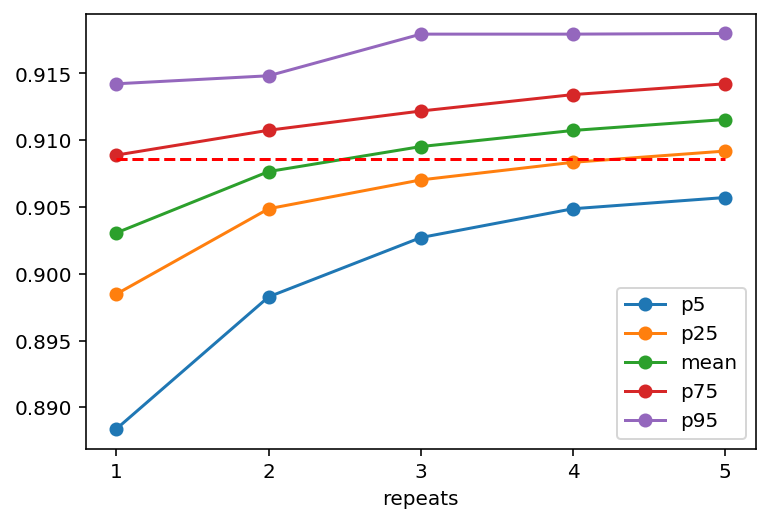

In [152]:
ax = df.plot(
    x="repeats",
    # y=["min", "p10", "mean", "p90", "max"],
    y=["p5", "p25", "mean", "p75", "p95"],
    style="o-",
)
ax.plot([1, 5], [h_pdf.mean(), h_pdf.mean()], "r--")
ax.set_xticks([1, 2, 3, 4, 5])